In [2]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

In [3]:
# 1. Define the state
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str
    step3: str

In [4]:
# 2. Define steps
def step_1(state: CrashState) -> CrashState:
    print("✅ Step 1 executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(10)  # Simulate long-running hang
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("✅ Step 3 executed")
    return {"step3": "done"}

In [5]:
# 3. Build the graph
builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

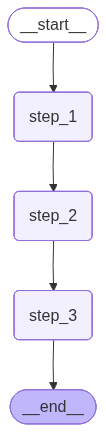

In [6]:
graph

In [7]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
✅ Step 1 executed
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
❌ Kernel manually interrupted (crash simulated).


In [8]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a2094-b1ab-6797-8001-447afb9c9fe9'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-05T16:35:24.693288+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a2094-b19c-6d64-8000-5f2142bc8fec'}}, tasks=(PregelTask(id='cc3dd364-ec7d-82ba-ee03-2f393c33db92', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a2094-b19c-6d64-8000-5f2142bc8fec'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-05T16:35:24.687293+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'ch

In [9]:
# 6. Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)


🔁 Re-running the graph to demonstrate fault tolerance...
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
✅ Step 3 executed

✅ Final State: {'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}


In [10]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a2095-c4a2-659f-8003-a5f53ed19e43'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-10-05T16:35:53.525391+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a2095-c4a2-659e-8002-00e406fa7a0f'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step_3',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a2095-c4a2-659e-8002-00e406fa7a0f'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-05T16:35:53.525391+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a2094-b1ab-6797-8001-447afb9c9fe9'}}, tasks=(PregelTask(id='0eeaeadf-d9e0-58ea